# Formation RNAseq CEA - juin 2023

*Enseignantes : Sandrine Caburet et Claire Vandiedonck*

Session IFB : 5 CPU + 21 GB de RAM

# Part 9: DESeq2 Normalisation and Differential Expression analysis


- 0. 1 - Setting up this R session on IFB core cluster  
- 0. 2 - Parameters to be set or modified by the user   
- 1 - Loading input data and metadata   
- 2 - Normalisation with 'DESeq2   
- 3 - Differential expression analysis with `DESeq2`   
- 4 - Saving our results for later use : RData file

---

## 0.1 - Setting up this R session on IFB core cluster

<em>loaded JupyterLab</em> : Version 3.2.1

In [1]:
## Code cell 1 ##

session_parameters <- function(){
    
    jupytersession <- c(system('echo "=== Cell launched on $(date) ==="', intern = TRUE),
                        system('squeue -hu $USER', intern = TRUE))
    
    jobid <- system("squeue -hu $USER | awk '/jupyter/ {print $1}'", intern = TRUE)
    jupytersession <- c(jupytersession,
                        "=== Current IFB session size: Medium (5CPU, 21 GB) ===",
                        system(paste("sacct --format=JobID,AllocCPUS,NODELIST -j", jobid), intern = TRUE))
    print(jupytersession[1:6])
    
    return(invisible(NULL))
}

session_parameters()

[1] "=== Cell launched on Thu Jun  1 23:22:54 CEST 2023 ==="                         
[2] "          33624239      fast  jupyter scaburet  R      37:55      1 cpu-node-27"
[3] "=== Current IFB session size: Medium (5CPU, 21 GB) ==="                         
[4] "       JobID  AllocCPUS        NodeList "                                       
[5] "------------ ---------- --------------- "                                       
[6] "33624239              5     cpu-node-27 "                                       


__

Next we load into this R session the various tools that we will use.   
***DO NOT worry*** if you see a large red output!!   
You should see this large red output only once, when the relevant packages are installed in your home directory. Afterwards, they will be detected as present, and this large red output won't show if you run the cell another time.

In [2]:
## Code cell 2 ##

if (!require("DESeq2", quietly = TRUE)) {
    install.packages("DESeq2")}

library("matrixStats")
library("DESeq2", quietly = TRUE)


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:base’:

    expand.grid



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:

In [3]:
## Code cell 3 ##   

cat("Voici mon environnement de travail avec les paquets de R chargés:\n")
sessionInfo()

Voici mon environnement de travail avec les paquets de R chargés:


R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /shared/ifbstor1/software/miniconda/envs/r-4.0.3/lib/libopenblasp-r0.3.10.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] DESeq2_1.30.1               SummarizedExperiment_1.20.0
 [3] Biobase_2.50.0              MatrixGenerics_1.2.1       
 [5] matrixStats_0.61.0          GenomicRanges_1.42.0       
 [7] GenomeInfoDb_1.26.7         IRanges_2.24.1             
 [9] S4Vectors_0.28.

---

## 0.2 - Parameters to be set or modified by the user


- Using a full path with a `/` at the end, **define the folder** of the project as  `gohome` variable, and the folder where you work as the `myfolder` variable:

In [4]:
## Code cell 4 ##


gohome <- "/shared/projects/2312_rnaseq_cea/"
gohome

# In a Jupyter Hub and a jupyter notebook in R, by default the working directory is where the notebook is opened
getwd()

setwd("/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet") # temporaire pour mettre le jupynb en place
myfolder <- getwd()

myfolder


[1] "/shared/projects/2312_rnaseq_cea/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/pipeline"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet"

- With a `/` at the end, define the path to the folder where the results of this normalisation by `DESeq2` will be stored:

In [5]:
## Code cell 5 ##

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste(myfolder,"/Results/deseq2/", sep = ""), recursive = TRUE)

# storing the path to this output folder in a variable
deseq2folder <- paste(myfolder,"/Results/deseq2/", sep = "")
deseq2folder

# listing the content of the folder
print(system(paste("ls -hlt", deseq2folder), intern = TRUE) )

Warning message in dir.create(paste(myfolder, "/Results/deseq2/", sep = ""), recursive = TRUE):
“'/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/deseq2' already exists”


[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/deseq2/"

[1] "total 37M"                                                                          
[2] "-rw-rw----+ 1 scaburet scaburet  37M Jun  1 19:36 deseq2.RData"                     
[3] "-rw-rw----+ 1 scaburet scaburet 356K Jun  1 19:33 DESeq2_significant_genes-0_05.tsv"


- Last, we specify the size of the graphical outputs that will be used for all the plots in the notebook.    
This setting could be modified at will for each plot. 

In [6]:
## Code cell 6 ##

options(repr.plot.width=15, repr.plot.height=8)

## 1 - Loading input data and metadata

We now need to retrieve the counts data and the metadata about samples.   
As we stored those in a global Rdata objet at the end of Pipe_08, we can simply reload all our information by openig this Rdata object.  


- the read counts produced by featureCounts (as in the Pipe_6 notebook), on all 11 samples   
- a metadata file, providing information about the samples, in particular the conditions of the experiment. 

In [7]:
## Code cell 7 ##

pca1folder <- paste0(myfolder,"/Results/pca1/")
pca1folder
rdata <- paste0(pca1folder,"AllMyData.RData")
rdata
load(rdata,verbose = T)

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/pca1/"

[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/Results/pca1/AllMyData.RData"

Loading objects:
  logcounts
  keep
  conditionColor
  countdata
  .Random.seed
  counts
  samples
  myfolder
  conditionCol
  countdata2
  clusters
  pca1folder
  session_parameters
  PCAdata
  tlogcounts
  gohome
  .pbd_env


We can now list all the object we have currently in our session: 

In [8]:
## Code cell 8 ##

ls() 

[1] "clusters"           "conditionCol"       "conditionColor"    
 [4] "countdata"          "countdata2"         "counts"            
 [7] "deseq2folder"       "gohome"             "keep"              
[10] "logcounts"          "myfolder"           "pca1folder"        
[13] "PCAdata"            "rdata"              "samples"           
[16] "session_parameters" "tlogcounts"

- `countdata`is a dataframe containing all the read counts produced by `featureCounts` (as in the Pipe_06 notebook), on all 11 samples, including low counts genes.
- `countdata2`is the same dataframe without the low counts genes      
- `samples`is a dataframe containing the information about the samples, in particular the conditions of the experiment. 

We don't need anything else from the previous session, so we can remove the other objects from our current R session, in order to save memory.

In [10]:
## Code cell 9 ##

rm(logcounts, counts, clusters, keep, pca1folder, PCAdata, tlogcounts)  
ls()

Warning message in rm(logcounts, counts, conditionColor, clusters, keep, pca1folder, :
“object 'logcounts' not found”
Warning message in rm(logcounts, counts, conditionColor, clusters, keep, pca1folder, :
“object 'counts' not found”
Warning message in rm(logcounts, counts, conditionColor, clusters, keep, pca1folder, :
“object 'conditionColor' not found”
Warning message in rm(logcounts, counts, conditionColor, clusters, keep, pca1folder, :
“object 'clusters' not found”
Warning message in rm(logcounts, counts, conditionColor, clusters, keep, pca1folder, :
“object 'keep' not found”
Warning message in rm(logcounts, counts, conditionColor, clusters, keep, pca1folder, :
“object 'pca1folder' not found”
Warning message in rm(logcounts, counts, conditionColor, clusters, keep, pca1folder, :
“object 'PCAdata' not found”
Warning message in rm(logcounts, counts, conditionColor, clusters, keep, pca1folder, :
“object 'tlogcounts' not found”


[1] "conditionCol"       "countdata"          "countdata2"        
[4] "deseq2folder"       "gohome"             "myfolder"          
[7] "rdata"              "samples"            "session_parameters"

We verify that the counts dataframes look like what we expect:

In [11]:
## Code cell 10 ##

head(countdata)
head(countdata2)

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000102693.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000064842.3,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000051951.6,0,0,0,0,0,0,0,1,0,0,0
ENSMUSG00000102851.2,0,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000103377.2,0,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104017.2,0,0,0,0,0,0,0,0,0,0,0


,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000025902.14,3,0,64,56,126,172,0,0,0,0,1
ENSMUSG00000104238.2,0,0,0,0,2,11,0,0,0,0,0
ENSMUSG00000102269.2,3,4,2,0,2,4,2,1,1,2,2
ENSMUSG00000098104.2,190,160,185,175,203,153,227,109,162,257,214
ENSMUSG00000102175.2,0,2,1,4,0,2,0,0,2,3,1
ENSMUSG00000103922.2,62,56,49,39,68,34,28,21,29,57,50


In [12]:
## Code cell 11 ##

head(samples, n=13)

,SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
2,SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
3,SRR12730405,dHet_B-ALL_713_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805162,GSM4805162,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
4,SRR12730406,dHet_B-ALL_713_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805163,GSM4805163,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 713)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
5,SRR12730407,dHet_B-ALL_760_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805164,GSM4805164,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
6,SRR12730408,dHet_B-ALL_760_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805165,GSM4805165,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 760)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
7,SRR12730409,dHet_FetalLiver_proB_rep1,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805166,GSM4805166,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
8,SRR12730410,dHet_FetalLiver_proB_rep2,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805167,GSM4805167,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver
9,SRR12730411,dHet_FetalLiver_proB_rep3,dHetRag,Ebf1+/- Pax5+/- Rag2-/-,GSM4805168,GSM4805168,"Ebf1+/- Pax5+/- dHet fetal liver proB cells\,Replicate3",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- Rag2-/- proB fetal liver


To ensure the metadata `samples` and `countdata` dataframes have the same samples names, we run the code below.    
This will return TRUE if the names in both files are the same. In all there are 11 samples in both files.

In [13]:
## Code cell 12 ##

table(colnames(countdata)==samples$SampleID)


TRUE 
  11 

**Great!!**. All is set now to perform normalisation and differential expression analysis with `DESeq2`.

---
## 2 - Normalisation with 'DESeq2'

All the steps required to perform normalisation of read counts and differential expression analysis has been placed into a single function, DESeq. More details on the respective steps can be found in the DESeq2 paper. You could also type and run ?DESeq to read more on the steps.

### 2.1 - Create the DESeqDataSet object from the countdata and metadata

DESeq2 uses an object called DESeqDataSet to store read counts and other intermediate calculations needed for normalisation and differential expression analysis. This is represented in the code below as dds (d for DESeq, d for Data and s for set). The basic idea behind this is to coerce the countdata and metadata into a single format that DESeq2 can accept and work with. We do this with the DESeqDataSetFromMatrix function.

In [14]:
## Code cell 13 ##

nrow(countdata)
nrow(countdata2)

# 57010 in countdata
# 22927 in countdata2

[1] 57010

[1] 22927

There are 57010 genes in our samples, because the genes with a null or a low expression were not filtered out.   
`DESeq2` takes care of these genes along the way, so we can keep those.   
Nevertheless, if you work in a low-memory setting, it is preferable to reduce the size of the matrix to ease its handling, by removing the low-expression genes the same way we did in Pipe_08, of by using as input the `countData2`dataframe that is already computed.   
Here, we will go on with the `countdata2`dataframe, without low counts genes.

**Factorisation**  

We have to tell DESeq2 which information is used as a *factor*, meaning the one that is going to be used as a way to separate groups for future comparison.   
This is done by using the `factor()` function, and providing the name of the column containing this information, and the various values that this info can take.   
Feeding this factorisation into our samples dataframe changes the way this column will be read: as a factor istead of mere characters. 
   
   The `relevel()` function can also be used to clearly specify which level is used as a reference. Most of the times, it will be the WT condition.  


In [15]:
## Code cell 14 ##

samples$Condition = factor(samples$Condition, levels = c("WT", "dHet", "dHetRag" ))

In [16]:
## Code cell 15 ##

samples$Condition = relevel(samples$Condition, ref = "WT")

We can verify that this factorisation worked, by showing how many samples were placed in each group:

In [17]:
## Code cell 16 ##

table(samples$Condition)


     WT    dHet dHetRag 
      2       6       3 

and by checking the levels included in that factor:

In [18]:
## Code cell 17 ##

levels(samples$Condition)

[1] "WT"      "dHet"    "dHetRag"

If we look at our `samples`dataframe, we can now see that our `Condition`column is marked as a factor: **fct**

In [19]:
## Code cell 18 ##

head(samples, n = 2)

,SampleID,SampleName,Condition,Genotype,GEO_Accession..exp.,Sample.Name,source_name,SRA.Study,Strain,Tissue
,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SRR12730403,dHet_B-ALL_686_rep1,dHet,Ebf1+/- Pax5+/-,GSM4805160,GSM4805160,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate1",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node
2,SRR12730404,dHet_B-ALL_686_rep2,dHet,Ebf1+/- Pax5+/-,GSM4805161,GSM4805161,"Ebf1+/- Pax5+/- dHet leukemic cells derived from lymph node (mouse 686)\,Replicate2",SRP285633,C57BL/6J,Ebf1+/- Pax5+/- lymph node


We can now create the `dds` object from our two dataframes:

In [20]:
## Code cell 19 ##

# round() is used as a security, because DESeq2 works only in integers. Read counts should be integers.

dds <- DESeq2::DESeqDataSetFromMatrix(countData = round(countdata2),
                              colData = samples,
                              design = ~Condition)

converting counts to integer mode



We check the number of genes in the dataset

In [21]:
## Code cell 20 ##

nrow(dds)

# 57010 in countdata
# 22927 in countdata2

[1] 22927

## 2.2 - Run the DESeq function to analyse the dds object

Next, the DEseq function performs the following steps on the dds object we created:

    Estimation of size factors
    Estimation of dispersion
    Negative Binomial GLM fitting and Wald statistic 
    
For detailed explanation, please refer to the DESeq2 paper.

In [22]:
## Code cell 21 ##

dds2 <- DESeq2::DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



Let's inspect the header of the newly created object

In [23]:
## Code cell 22 ##

head(dds2)

class: DESeqDataSet 
dim: 6 11 
metadata(1): version
assays(4): counts mu H cooks
rownames(6): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00000102175.2 ENSMUSG00000103922.2
rowData names(26): baseMean baseVar ... deviance maxCooks
colnames(11): SRR12730403 SRR12730404 ... SRR12730412 SRR12730413
colData names(11): SampleID SampleName ... Tissue sizeFactor

The portion `assay` within `dds` contains the expression data, still not normalized :

In [24]:
## Code cell 23 ##

head(assay(dds2))

,SRR12730403,SRR12730404,SRR12730405,SRR12730406,SRR12730407,SRR12730408,SRR12730409,SRR12730410,SRR12730411,SRR12730412,SRR12730413
ENSMUSG00000025902.14,3,0,64,56,126,172,0,0,0,0,1
ENSMUSG00000104238.2,0,0,0,0,2,11,0,0,0,0,0
ENSMUSG00000102269.2,3,4,2,0,2,4,2,1,1,2,2
ENSMUSG00000098104.2,190,160,185,175,203,153,227,109,162,257,214
ENSMUSG00000102175.2,0,2,1,4,0,2,0,0,2,3,1
ENSMUSG00000103922.2,62,56,49,39,68,34,28,21,29,57,50


In [25]:
## Code cell 24 ##

summary(assay(dds2))

  SRR12730403      SRR12730404      SRR12730405      SRR12730406    
 Min.   :     0   Min.   :     0   Min.   :     0   Min.   :     0  
 1st Qu.:     5   1st Qu.:     4   1st Qu.:     4   1st Qu.:     4  
 Median :    70   Median :    60   Median :    50   Median :    56  
 Mean   :  1884   Mean   :  1471   Mean   :  1338   Mean   :  1393  
 3rd Qu.:  1435   3rd Qu.:  1174   3rd Qu.:  1022   3rd Qu.:  1095  
 Max.   :380993   Max.   :294250   Max.   :460910   Max.   :465330  
  SRR12730407      SRR12730408      SRR12730409      SRR12730410      
 Min.   :     0   Min.   :     0   Min.   :     0   Min.   :     0.0  
 1st Qu.:     3   1st Qu.:     3   1st Qu.:     3   1st Qu.:     3.0  
 Median :    51   Median :    55   Median :    43   Median :    38.0  
 Mean   :  1549   Mean   :  1411   Mean   :  1152   Mean   :  1218.1  
 3rd Qu.:  1222   3rd Qu.:  1180   3rd Qu.:   918   3rd Qu.:   901.5  
 Max.   :254944   Max.   :212782   Max.   :169735   Max.   :187547.0  
  SRR12730411       

We can verify this by plotting the distribution of read counts (with a log2 transformation) using a boxplot, to verify that the read counts have indeed not yet been normalized between samples.

In [26]:
## Code cell 25 ##

# Get log2 counts
logcountsdds2 <- log2(assay(dds2) + 1)
# summary(logcounts[,1]) # summary for first column
 summary(logcountsdds2) # summary for each column

  SRR12730403      SRR12730404      SRR12730405      SRR12730406    
 Min.   : 0.000   Min.   : 0.000   Min.   : 0.000   Min.   : 0.000  
 1st Qu.: 2.585   1st Qu.: 2.322   1st Qu.: 2.322   1st Qu.: 2.322  
 Median : 6.150   Median : 5.931   Median : 5.672   Median : 5.833  
 Mean   : 6.523   Mean   : 6.266   Mean   : 6.097   Mean   : 6.219  
 3rd Qu.:10.488   3rd Qu.:10.199   3rd Qu.: 9.999   3rd Qu.:10.098  
 Max.   :18.539   Max.   :18.167   Max.   :18.814   Max.   :18.828  
  SRR12730407     SRR12730408      SRR12730409      SRR12730410    
 Min.   : 0.00   Min.   : 0.000   Min.   : 0.000   Min.   : 0.000  
 1st Qu.: 2.00   1st Qu.: 2.000   1st Qu.: 2.000   1st Qu.: 2.000  
 Median : 5.70   Median : 5.807   Median : 5.459   Median : 5.285  
 Mean   : 6.09   Mean   : 6.164   Mean   : 5.870   Mean   : 5.785  
 3rd Qu.:10.26   3rd Qu.:10.206   3rd Qu.: 9.844   3rd Qu.: 9.818  
 Max.   :17.96   Max.   :17.699   Max.   :17.373   Max.   :17.517  
  SRR12730411      SRR12730412      SRR12

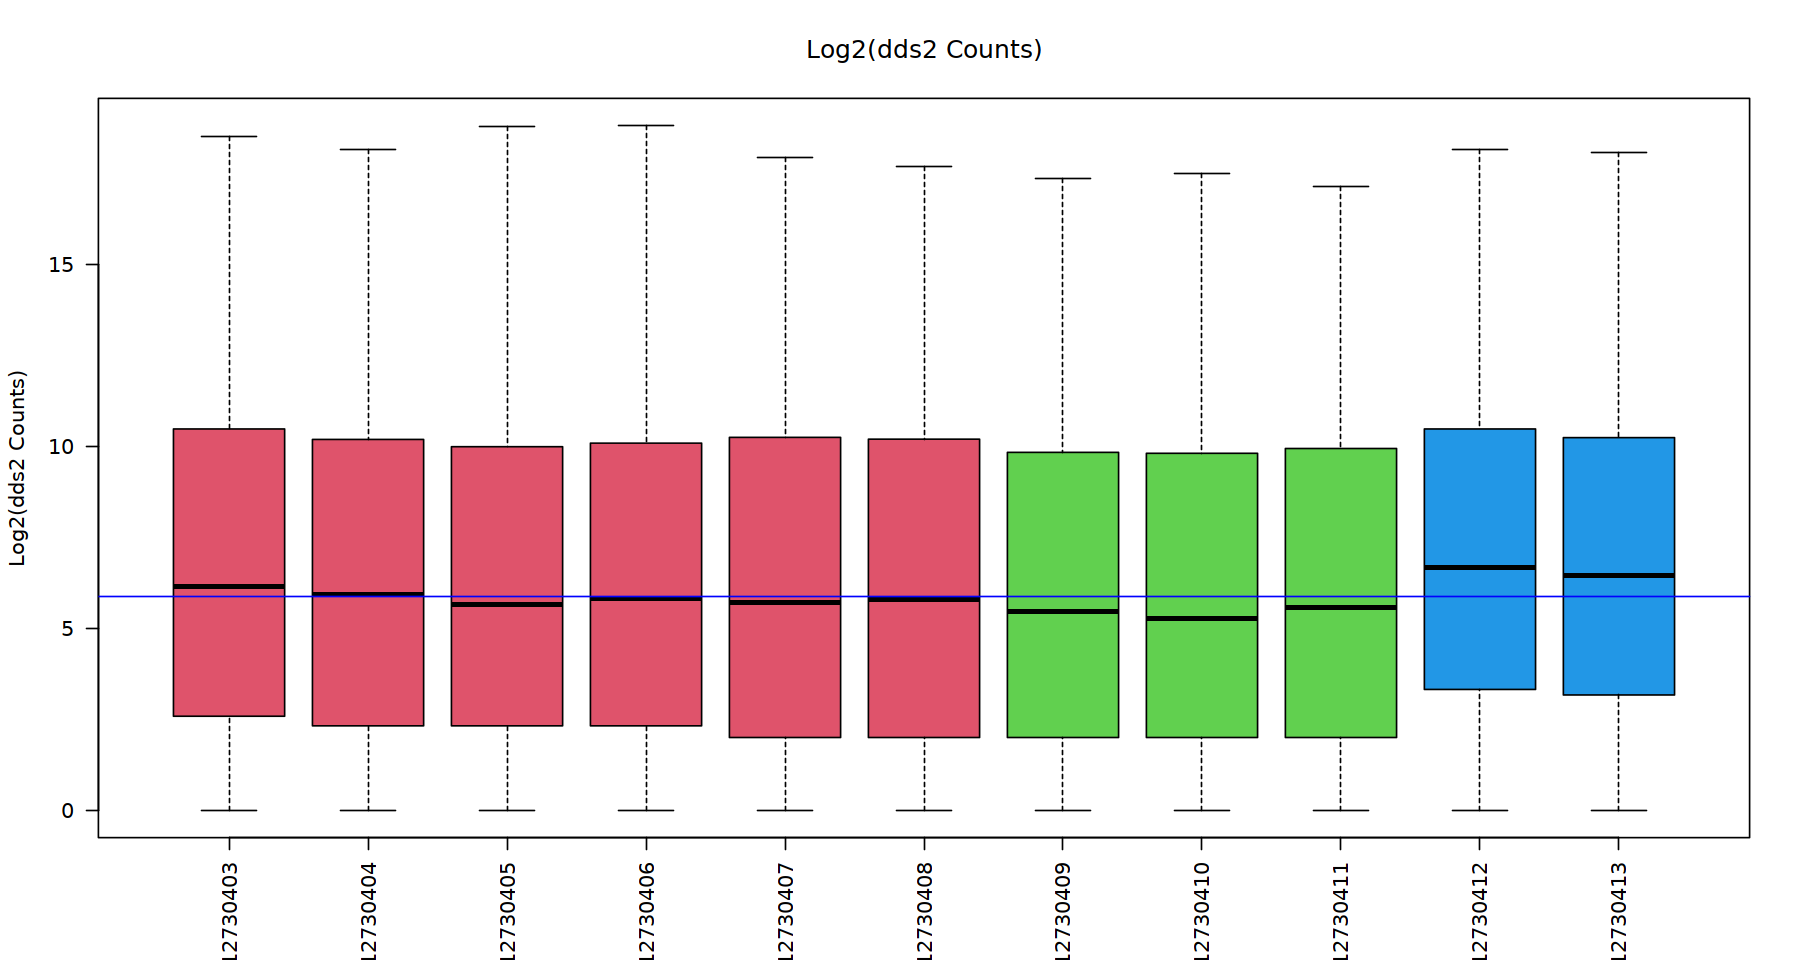

In [28]:
## Code cell 26 ##

# make a colour vector
conditionColor <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# Check distributions of samples using boxplots
boxplot(logcountsdds2,
        xlab="",
        ylab="Log2(dds2 Counts)",
        las=2,
        col=conditionColor,
        main="Log2(dds2 Counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(as.matrix(logcountsdds2)), col="blue")


As we can see, the log2 transformation gives a data distribution closer to the normal distribution, but does not perform well for normalizing data between samples.    

The main motive behind normalization is to change numeric values in a dataset to a common scale without distorting the differences between samples. This reduces the sparsity of the data as they are brought to a common close scale. There are several normalization methods that can be applied to our data.

DESeq2 provides 2 normalisation methods: `rlog`and `vst`.  
We will test the effect of both. 

## 2.3 - Data normalisation with `rlog`: Regularized-logarithm transformation

This function transforms the count data to the log2 scale in a way which minimizes differences between samples for rows with small counts, and which normalizes with respect to library size.

> *In the function calls, we specified `blind = FALSE`, which means that differences between cell lines and treatment (the variables in the design) will not contribute to the expected variance-mean trend of the experiment. The experimental design is not used directly in the transformation, only in estimating the global amount of variability in the counts. For a fully **unsupervised** transformation, one can set `blind = TRUE` (which is the default).*   
[Love MI *et al.*, 2019](https://www.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#the-variance-stabilizing-transformation-and-the-rlog)

`blind=FALSE` greatly reduces the run time.

In [29]:
## Code cell 27 ##

rlog.dds2 <- rlog(dds2, blind = FALSE)
rlog.dds2

class: DESeqTransform 
dim: 22927 11 
metadata(1): version
assays(1): ''
rownames(22927): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00000095742.2 ENSMUSG00000095041.8
rowData names(27): baseMean baseVar ... maxCooks rlogIntercept
colnames(11): SRR12730403 SRR12730404 ... SRR12730412 SRR12730413
colData names(11): SampleID SampleName ... Tissue sizeFactor

Let's verify the effect by plotting the log2 counts from `rlog.dds2`

In [30]:
## Code cell 28 ##

# Get log2 counts
logcounts.rlog.dds2 <- log2(assay(rlog.dds2) + 1)

summary(logcounts.rlog.dds2) # summary for each column

  SRR12730403      SRR12730404      SRR12730405      SRR12730406    
 Min.   :-2.932   Min.   :-2.904   Min.   :-2.884   Min.   :-2.892  
 1st Qu.: 1.638   1st Qu.: 1.636   1st Qu.: 1.652   1st Qu.: 1.665  
 Median : 2.737   Median : 2.753   Median : 2.746   Median : 2.756  
 Mean   : 2.457   Mean   : 2.463   Mean   : 2.466   Mean   : 2.473  
 3rd Qu.: 3.470   3rd Qu.: 3.473   3rd Qu.: 3.475   3rd Qu.: 3.476  
 Max.   : 4.256   Max.   : 4.254   Max.   : 4.309   Max.   : 4.305  
  SRR12730407      SRR12730408      SRR12730409      SRR12730410    
 Min.   :-2.905   Min.   :-2.901   Min.   :-2.840   Min.   :-2.833  
 1st Qu.: 1.578   1st Qu.: 1.605   1st Qu.: 1.623   1st Qu.: 1.614  
 Median : 2.706   Median : 2.737   Median : 2.719   Median : 2.688  
 Mean   : 2.436   Mean   : 2.450   Mean   : 2.449   Mean   : 2.438  
 3rd Qu.: 3.478   3rd Qu.: 3.477   3rd Qu.: 3.469   3rd Qu.: 3.467  
 Max.   : 4.239   Max.   : 4.225   Max.   : 4.222   Max.   : 4.232  
  SRR12730411      SRR12730412    

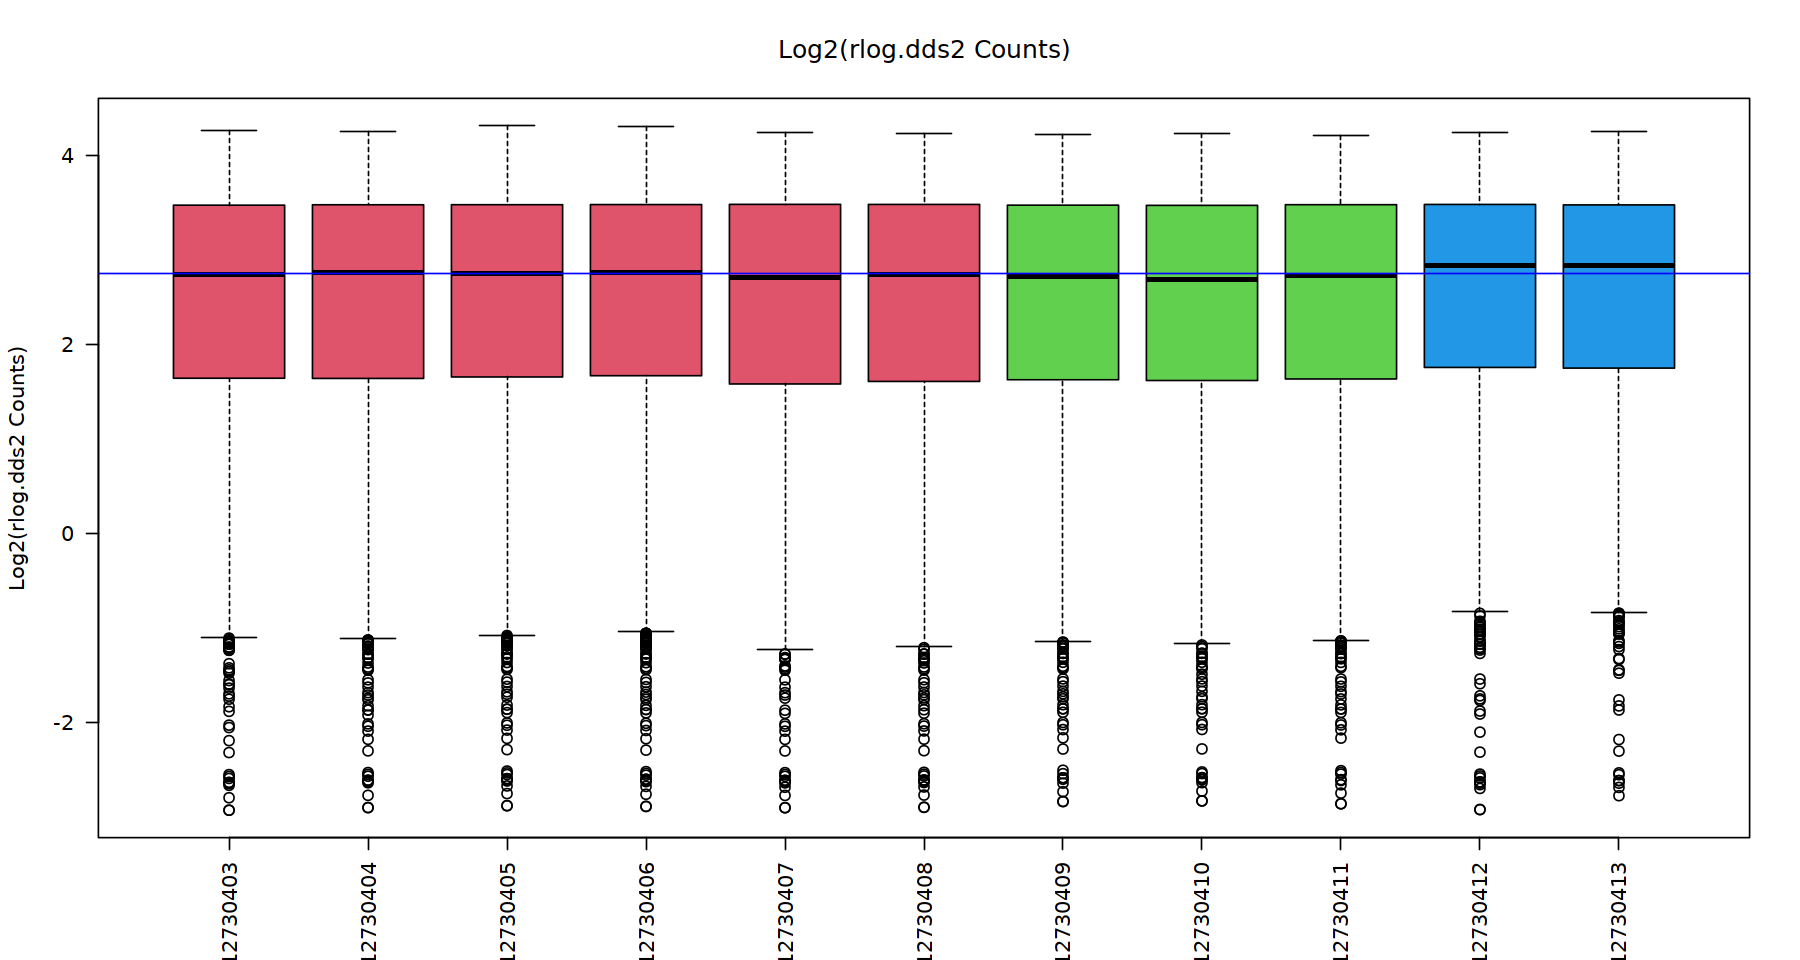

In [31]:
## Code cell 29 ##

# make a colour vector
conditionCol <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# Check distributions of samples using boxplots
boxplot(logcounts.rlog.dds2,
        xlab="",
        ylab="Log2(rlog.dds2 Counts)",
        las=2,
        col=conditionCol,
        main="Log2(rlog.dds2 Counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(as.matrix(logcounts.rlog.dds2)), col="blue")

We can verify that variance is not correlated any more to the average level of expression by plotting standard deviation vs mean expression:

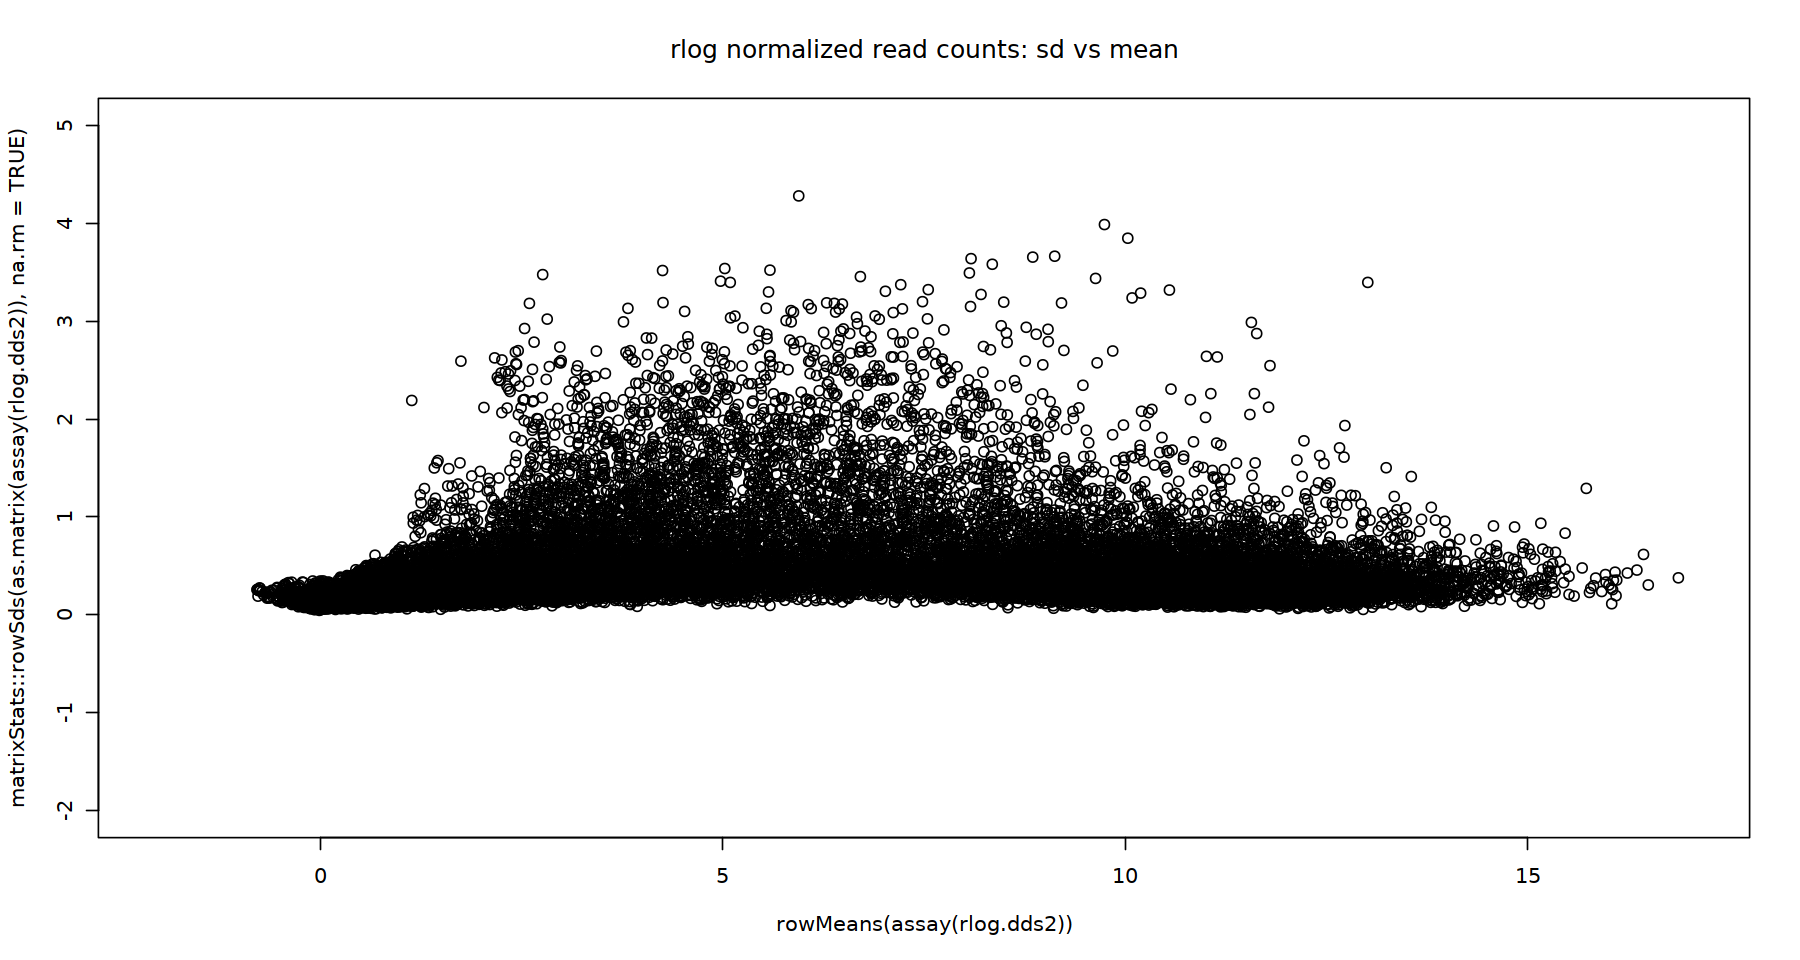

In [32]:
## Code cell 30 ##

# Raw counts mean expression Vs standard Deviation (SD)
plot(rowMeans(assay(rlog.dds2)), matrixStats::rowSds(as.matrix(assay(rlog.dds2)), na.rm=TRUE), 
     main='rlog normalized read counts: sd vs mean', 
     xlim=c(-2,17),
     ylim=c(-2,5))

## 2.4 - Normalization with `vst`: variance stabilizing transformation

Variance stabilizing transformation (VST) aims at generating a matrix of values for which variance is constant across the range of mean values, especially for low mean.

The vst function computes the fitted dispersion-mean relation, derives the transformation to apply and accounts for library size.

In [33]:
## Code cell 31 ##

vst.dds2 = vst(dds2, blind=FALSE)
vst.dds2

class: DESeqTransform 
dim: 22927 11 
metadata(1): version
assays(1): ''
rownames(22927): ENSMUSG00000025902.14 ENSMUSG00000104238.2 ...
  ENSMUSG00000095742.2 ENSMUSG00000095041.8
rowData names(26): baseMean baseVar ... maxCooks dispFit
colnames(11): SRR12730403 SRR12730404 ... SRR12730412 SRR12730413
colData names(11): SampleID SampleName ... Tissue sizeFactor

Again, we check the effect by plotting the log2 counts from `vst.dds2`

In [34]:
## Code cell 32 ##

# Get log2 counts
logcounts.vst.dds2 <- log2(assay(vst.dds2) + 1)

summary(logcounts.vst.dds2) # summary for each column

  SRR12730403     SRR12730404     SRR12730405     SRR12730406   
 Min.   :2.806   Min.   :2.806   Min.   :2.806   Min.   :2.806  
 1st Qu.:2.876   1st Qu.:2.877   1st Qu.:2.882   1st Qu.:2.880  
 Median :3.047   Median :3.055   Median :3.051   Median :3.057  
 Mean   :3.183   Mean   :3.185   Mean   :3.185   Mean   :3.188  
 3rd Qu.:3.489   3rd Qu.:3.494   3rd Qu.:3.496   3rd Qu.:3.498  
 Max.   :4.257   Max.   :4.254   Max.   :4.318   Max.   :4.313  
  SRR12730407     SRR12730408     SRR12730409     SRR12730410   
 Min.   :2.806   Min.   :2.806   Min.   :2.806   Min.   :2.806  
 1st Qu.:2.867   1st Qu.:2.868   1st Qu.:2.874   1st Qu.:2.874  
 Median :3.037   Median :3.048   Median :3.042   Median :3.031  
 Mean   :3.179   Mean   :3.183   Mean   :3.177   Mean   :3.174  
 3rd Qu.:3.499   3rd Qu.:3.499   3rd Qu.:3.489   3rd Qu.:3.487  
 Max.   :4.238   Max.   :4.221   Max.   :4.217   Max.   :4.229  
  SRR12730411     SRR12730412     SRR12730413   
 Min.   :2.806   Min.   :2.806   Min.   :

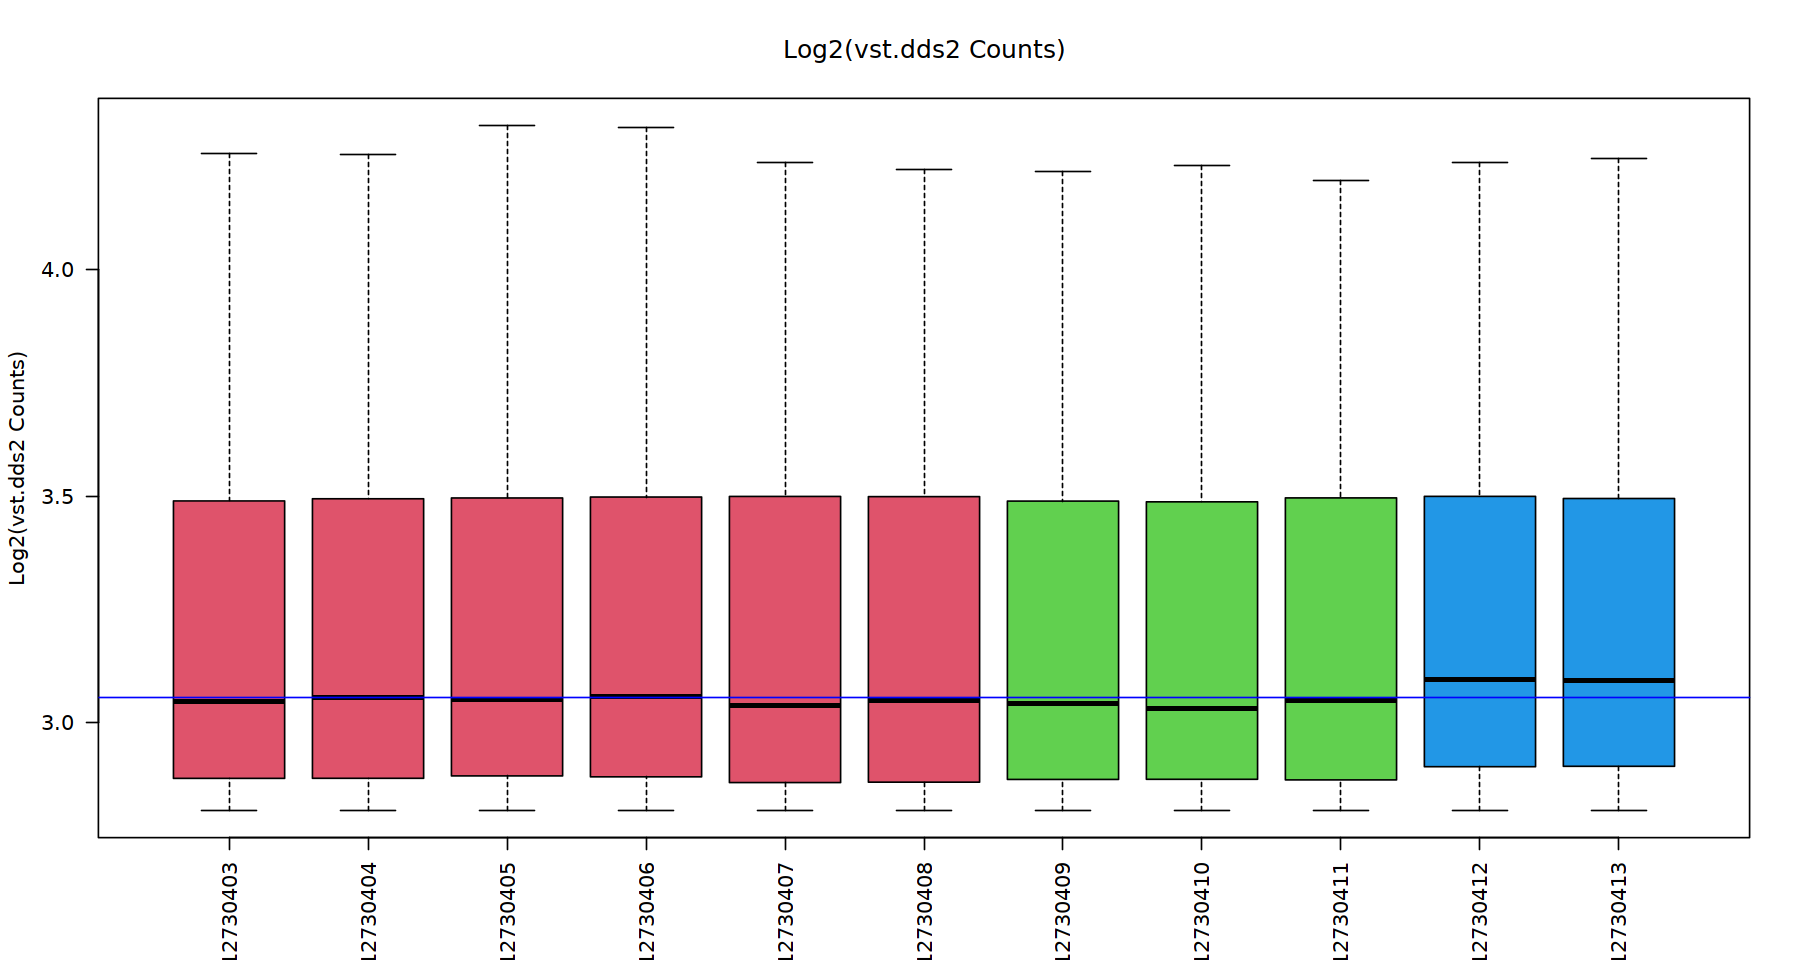

In [35]:
## Code cell 33 ##

# make a colour vector
conditionCol <- match(samples$Condition, c("dHet", "dHetRag", "WT")) + 1
# '+1' to avoid color '1' i.e. black

# Check distributions of samples using boxplots
boxplot(logcounts.vst.dds2,
        xlab="",
        ylab="Log2(vst.dds2 Counts)",
        las=2,
        col=conditionCol,
        main="Log2(vst.dds2 Counts)")
# Let's add a blue horizontal line that corresponds to the median
abline(h=median.default(as.matrix(logcounts.vst.dds2)), col="blue")

We also verify the decoupling of variance and mean level of expression:

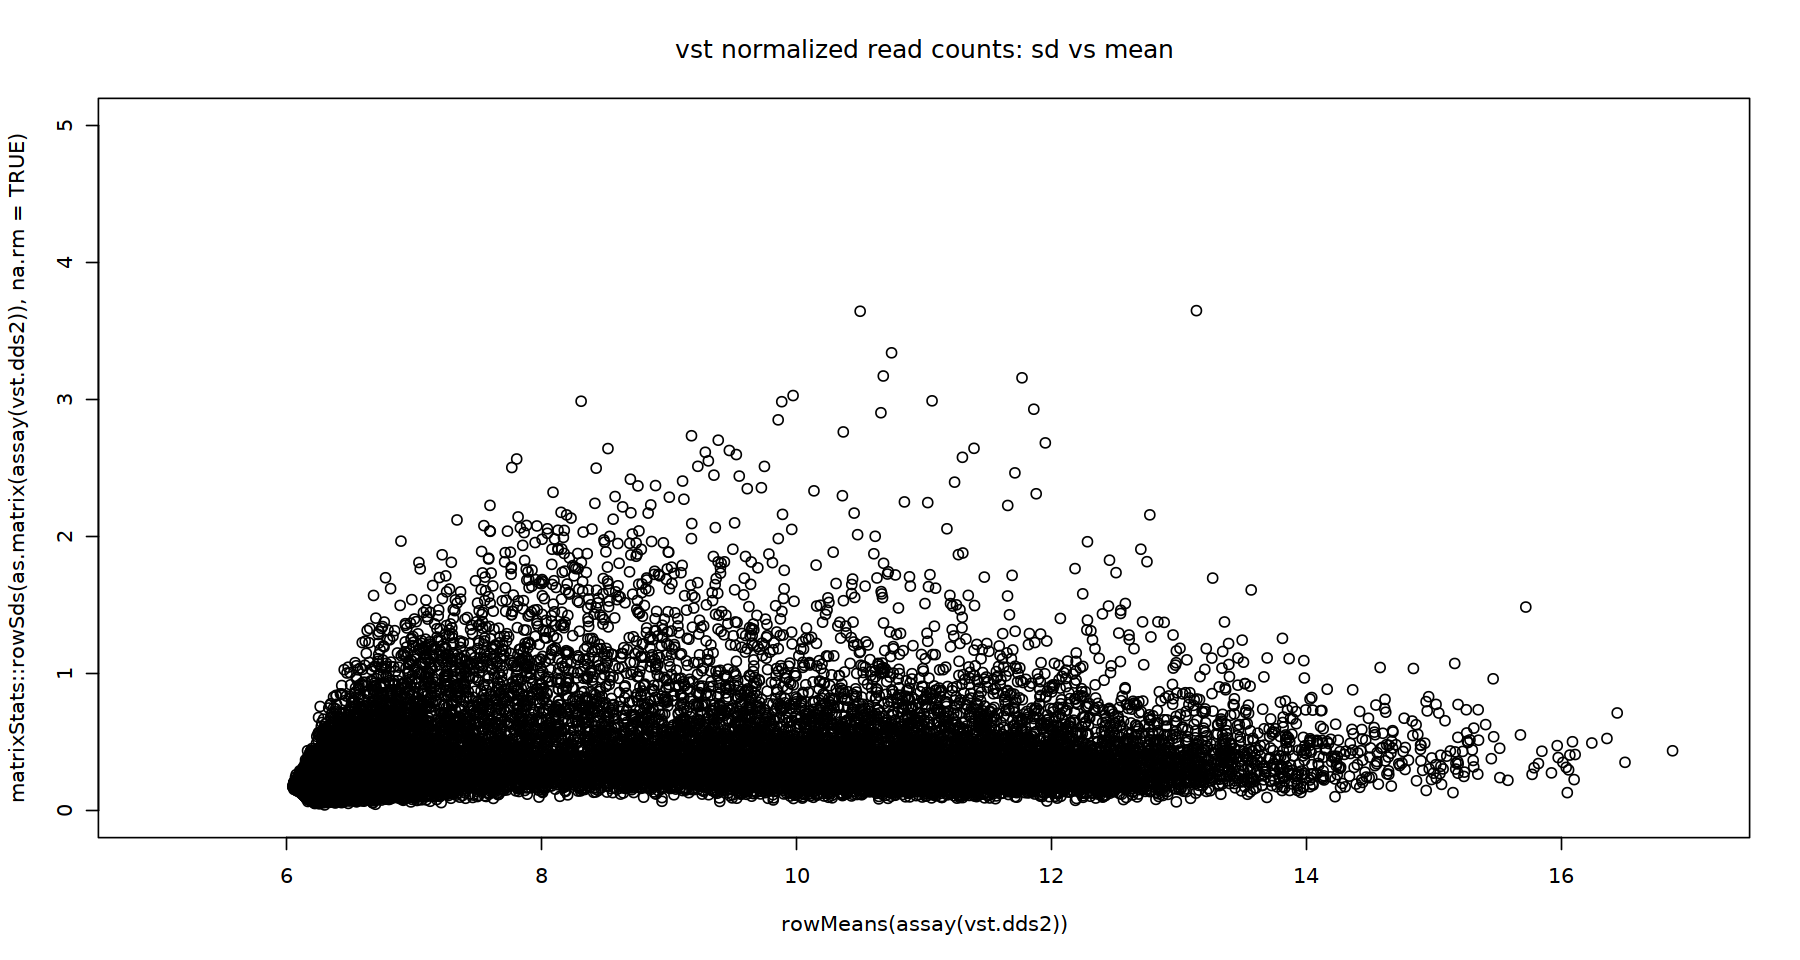

In [36]:
## Code cell 34 ##

# Raw counts mean expression Vs standard Deviation (SD)
plot(rowMeans(assay(vst.dds2)), matrixStats::rowSds(as.matrix(assay(vst.dds2)), na.rm=TRUE), 
     main='vst normalized read counts: sd vs mean', 
     xlim=c(5,17),
     ylim=c(0,5))

## 2.5- Choosing best transformation for our data

You can see that both methods worked on our data, even if the output are different.   
    
The indications to guide the choice between the two methods are:

> *For genes with high counts, both the VST and the rlog will give similar result to the ordinary log2 transformation of normalized counts. For genes with lower counts, however, the values are shrunken towards a middle value. The VST or rlog-transformed data then become approximately homoskedastic (more flat trend in the meanSdPlot), and can be used directly for computing distances between samples, making PCA plots, or as input to downstream methods which perform best with homoskedastic data.  
> **Which transformation to choose?** The VST is much faster to compute and is less sensitive to high count outliers than the rlog. The rlog tends to work well on small datasets (n < 30), potentially outperforming the VST when there is a wide range of sequencing depth across samples (an order of magnitude difference). We therefore recommend the VST for medium-to-large datasets (n > 30). You can perform both transformations and compare the meanSdPlot or PCA plots generated, as described below.*  
[Love MI *et al.*, 2019](https://www.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#the-variance-stabilizing-transformation-and-the-rlog)


Both tranformation methods performed well on our dataset, but we can notice that, in the rlog normalisation, although we have outliers for low values, the distribution appear more centered on the median for each sample.  

Thus, we will keep the **rlog** transformation to go on with the the second exploratory analysis in the next notebook. 

---
## 3 - Differential expression analysis with `DESeq2`

### 3.1 - Building the results table

The `results` table is a dataframe that contains our differentially expressed genes, their p-values, whether the genes are upregulated or downregulated, the number of outliers, etc.  
`summary()` gives us the genes that are up and down regulated in our condition under study, as well as low count genes and outliers. This generates summary tarries for the data. You can read about more about the results function by looking up ?results

We begin by defining the contrast, that is the comparison that we want to perform.    
Here we choose to compare the ALL cells to the WT ones: 

In [37]:
## Code cell 35 ##

contrastALL=c("Condition", "dHet","WT")

Now we can run DESeq2 for this comparison. It will not work on the normalised rlog.dds2, but on the not-yet normalised dds2 : indeed the normalisation step has to take into account the inter-group variability, and the intra-group variability to be correct, meaning that... the groups have to be defined first!   
Now that DESeq2 knows which group we want to compare, thanks to the `contrast` defined above, it will run the normalisation on the fly, and identify the genes that are significantly differentially expressed (DE genes) according to that specific normalisation.  

In [38]:
## Code cell 36 ##

res_table <- results(dds2, contrast = contrastALL)
summary(res_table)


out of 22927 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 3309, 14%
LFC < 0 (down)     : 3542, 15%
outliers [1]       : 29, 0.13%
low counts [2]     : 2223, 9.7%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Here, we found very few outliers, and we have 9.7% of low counts genes.   
The threshold used to considered a gene as significantly diffrentially expressed is a adjusted p-value of 0.1. Adjusted p-value means that a correction have been performed on the raw p-value, to take into consideration that the statistical test have been reiterated many times, as many as the number of genes. On such a high number of tests, some will give a "significant result" only by chance.   
The most-commonly used p-value correction is the **Benjamini-Hochberg method**, it is the one used by default by `DESeq2`. You could specify another one in the argument of the function.  

We obtain 3309 significantly up-regulated genes + 3542 significantly down-regulated genes. LFC stands for Log2 Fold Change, that is the ratio of the expression of a given gene in the test conditon on its expression in the Reference condition, in log2 scale. Therefore, un log2 FC of 1 means that the gene is 2-times more expressed in the test samples versus the reference samples.

### 3.2 - Working with a different threshold: alpha 0.05

By default, the result function uses an adjusted p-value cutoff of 0.1. If any other p value is prefered, `alpha` should be set to that value, as shown below where we set `alpha=0.05`.

In [40]:
## Code cell 37 ##

results2 <- results(dds2, alpha=0.05)

We can now count the number of differentially expressed genes with adjusted p-values were less than 0.05. na.rm=TRUE removes any row with missing information.

In [41]:
## Code cell 38 ##

sum(results2$padj < 0.05, na.rm=TRUE)
summary(results2)

# 2759 

[1] 2759


out of 22927 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 909, 4%
LFC < 0 (down)     : 1850, 8.1%
outliers [1]       : 29, 0.13%
low counts [2]     : 3112, 14%
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



So out of the 22927 filtered genes, only 2759 have adjusted p-values less than 0.05, with 909 significantly up-regulated genes + 1850 significantly down-regulated genes. Let’s go ahead and select them.

In [42]:
## Code cell 39 ##

res2_sig_genes <- subset(results2, padj < 0.05)
dim(res2_sig_genes)

## 2759     6

[1] 2759    6

We then order the selected genes by the smallest p value:

In [43]:
## Code cell 40 ##

res2_ranked_p <- res2_sig_genes[order(res2_sig_genes$pvalue),]
dim(res2_ranked_p)

## [1] 2759     6

[1] 2759    6

Finally, we write the differentially expressed gene list to a tabulated txt file, in the deseq2folder that we decided at first:

In [44]:
## Code cell 41 ##

write.table(as.data.frame(res2_ranked_p), file=paste0(deseq2folder,"DESeq2_significant_genes-0_05.tsv"), sep="\t", quote=F, col.names=T)

## 4 - Saving our results for later use: RData file

We can save all the R objects created in this session in a single R object.   
This will help us to reload our results without having to run the same commands.   

In [45]:
## Code cell 42 ##

print(ls())

 [1] "conditionCol"        "conditionColor"      "contrastALL"        
 [4] "countdata"           "countdata2"          "dds"                
 [7] "dds2"                "deseq2folder"        "gohome"             
[10] "logcounts.rlog.dds2" "logcounts.vst.dds2"  "logcountsdds2"      
[13] "myfolder"            "rdata"               "res_table"          
[16] "res2_ranked_p"       "res2_sig_genes"      "results2"           
[19] "rlog.dds2"           "samples"             "session_parameters" 
[22] "vst.dds2"           


We keep only the relevant objects:

In [46]:
## Code cell 43 ##

rm(conditionCol, countdata, dds, logcounts.vst.dds2, res_table, results2, res2_sig_genes, vst.dds2)

and we save all our info in a single RData object in our output folder:

In [47]:
## Code cell 44 ##

ls()
save.image(file=paste0(deseq2folder,"deseq2.RData"))

[1] "conditionColor"      "contrastALL"         "countdata2"         
 [4] "dds2"                "deseq2folder"        "gohome"             
 [7] "logcounts.rlog.dds2" "logcountsdds2"       "myfolder"           
[10] "rdata"               "res2_ranked_p"       "rlog.dds2"          
[13] "samples"             "session_parameters"

---
___

Now we go on with the visualization of normalized read counts in a full exploratory analysis.  
  
**=> Step 10: Exploratory analysis of normalized data** 

The jupyter notebook used for the next session will be *Pipe_10-R403-Normcounts-exploratory-analysis-II.ipynb*    
Let's retrieve it in our directory, in order to have a private copy to work on:   

In [48]:
## Code cell 45 ##   

myfolder

file.copy("/shared/projects/2312_rnaseq_cea/pipeline/Pipe_10-R403-Normcounts-exploratory-analysis-II.ipynb", myfolder)


[1] "/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet"

[1] FALSE



**Save executed notebook**

To end the session, save your executed notebook in your `run_notebooks' folder. Adjust the name with yours and reformat as code cell to run it.

In [49]:
## Code cell 46 ##   

# creation of the directory, recursive = TRUE is equivalent to the mkdir -p in Unix
dir.create(paste0(myfolder,"/run_notebooks"), recursive = TRUE)

runfolder <- paste0(myfolder,"/run_notebooks")
       
file.copy(paste0(myfolder, "/Pipe_09-R403-DESeq2-normalisation-DE.ipynb"), runfolder)


Warning message in dir.create(paste0(myfolder, "/run_notebooks"), recursive = TRUE):
“'/shared/ifbstor1/projects/2312_rnaseq_cea/scaburet/run_notebooks' already exists”


[1] TRUE

<div class="alert alert-block alert-success"><b>Success:</b> Well done! You now know how to perform a normalisation and a differential expression analysis using DESeq2.<br>
Don't forget to save you notebook and export a copy as an <b>html</b> file as well <br>
- Open "File" in the Menu<br>
- Select "Export Notebook As"<br>
- Export notebook as HTML<br>
- You can then open it in your browser even without being connected to the server! 
</div>

---
---

## Useful commands
<div class="alert alert-block alert-info"> 
    
- <kbd>CTRL</kbd>+<kbd>S</kbd> : save notebook<br>    
- <kbd>CTRL</kbd>+<kbd>ENTER</kbd> : Run Cell<br>  
- <kbd>SHIFT</kbd>+<kbd>ENTER</kbd> : Run Cell and Select Next<br>   
- <kbd>ALT</kbd>+<kbd>ENTER</kbd> : Run Cell and Insert Below<br>   
- <kbd>ESC</kbd>+<kbd>y</kbd> : Change to *Code* Cell Type<br>  
- <kbd>ESC</kbd>+<kbd>m</kbd> : Change to *Markdown* Cell Type<br> 
- <kbd>ESC</kbd>+<kbd>r</kbd> : Change to *Raw* Cell Type<br>    
- <kbd>ESC</kbd>+<kbd>a</kbd> : Create Cell Above<br> 
- <kbd>ESC</kbd>+<kbd>b</kbd> : Create Cell Below<br> 

<em>  
To make nice html reports with markdown: <a href="https://dillinger.io/" title="dillinger.io">html visualization tool 1</a> or <a href="https://stackedit.io/app#" title="stackedit.io">html visualization tool 2</a>, <a href="https://www.tablesgenerator.com/markdown_tables" title="tablesgenerator.com">to draw nice tables</a>, and the <a href="https://medium.com/analytics-vidhya/the-ultimate-markdown-guide-for-jupyter-notebook-d5e5abf728fd" title="Ultimate guide">Ultimate guide</a>. <br>
Further reading on JupyterLab notebooks: <a href="https://jupyterlab.readthedocs.io/en/latest/user/notebook.html" title="Jupyter Lab">Jupyter Lab documentation</a>.<br>   
</em>    
 
</div>

Bénédicte Noblet - 05-07 2021   
Sandrine Caburet et Claire Vandiedonck - 02-06 2023   
with adaptations from https://bioinformatics-core-shared-training.github.io/RNAseq_November_2020_remote/html/02_Preprocessing_Data.html   
and https://rpubs.com/adoughan/778146  
Maj 01/06/2023 par @SCaburet   